# Kaggle team name: vijf5!

# Members:
1. Jesse Coenraad -> JesseCoenraad
2. Jordan van Sintanneland -> JordanvanSint
3. Casper Priem -> CasperPriem
4. Jassar Hasiba -> UrClades

## Imports

In [18]:
import os
import librosa as lr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
import pandas as pd

In [19]:
label_genre = pd.read_csv('labels_new.csv')

label_genre.head()

,filename,genre
0,m00248.wav,metal
1,m00230.wav,country
2,m00637.wav,hiphop
3,m00627.wav,metal
4,m00138.wav,reggae


In [20]:
#make a list object of unique genres in labels dataframe
genres = list(label_genre['genre'].unique())
genres


['metal',
 'country',
 'hiphop',
 'reggae',
 'classical',
 'jazz',
 'rock',
 'pop',
 'blues',
 'disco']

# Feature engineering

In [21]:
from pathlib import Path
import os

In [22]:
os.listdir('labeled')

['m00002.wav',
 'm00039.wav',
 'm00041.wav',
 'm00072.wav',
 'm00096.wav',
 'm00102.wav',
 'm00112.wav',
 'm00138.wav',
 'm00192.wav',
 'm00206.wav',
 'm00230.wav',
 'm00236.wav',
 'm00248.wav',
 'm00253.wav',
 'm00298.wav',
 'm00313.wav',
 'm00338.wav',
 'm00339.wav',
 'm00351.wav',
 'm00400.wav',
 'm00421.wav',
 'm00429.wav',
 'm00435.wav',
 'm00454.wav',
 'm00477.wav',
 'm00501.wav',
 'm00503.wav',
 'm00513.wav',
 'm00553.wav',
 'm00606.wav',
 'm00623.wav',
 'm00627.wav',
 'm00629.wav',
 'm00633.wav',
 'm00637.wav',
 'm00658.wav',
 'm00671.wav',
 'm00676.wav',
 'm00677.wav',
 'm00678.wav',
 'm00716.wav',
 'm00762.wav',
 'm00772.wav',
 'm00773.wav',
 'm00801.wav',
 'm00821.wav',
 'm00850.wav',
 'm00867.wav',
 'm00895.wav',
 'm00996.wav']

In [23]:
# Define the base directory where the subdirectories "cat" and "dog" are located
base_dir = "labeled"  # Replace with your directory path

# Initialize lists for audio data and labels
audio_data = []
sample_freqs = []
labels = []

# Target length for 5 seconds at a sample rate of 22050 Hz (adjust if different)
target_length = 5 * 22050

# Process each audio file
for label in label_genre['filename']:
    sub_dir = os.path.join(base_dir)
    for file in os.listdir(sub_dir):
        if file.endswith(".wav"):
            file_path = os.path.join(sub_dir, file)
            data, sfreq = lr.load(file_path, sr=None)  # Keep original sample rate

            # Truncate or pad the audio
            if len(data) > target_length:
                # Truncate the data
                data = data[:target_length]
            elif len(data) < target_length:
                # Pad with zeros
                padding = target_length - len(data)
                data = np.pad(data, (0, padding), mode='constant')

            # Append the processed data and label
            audio_data.append(data)
            sample_freqs.append(sfreq)
            labels.append(label)

audio_data = np.stack(audio_data, axis=0)
sample_freqs = np.array(sample_freqs)
labels = np.array(labels)

In [24]:
print(audio_data[:5], labels[:5])

[[-0.01635742 -0.02282715 -0.01467896 ...  0.00747681  0.00817871
   0.00772095]
 [-0.0947876  -0.15338135 -0.1439209  ... -0.18804932 -0.09313965
  -0.0645752 ]
 [ 0.07803345 -0.03765869  0.12664795 ...  0.06295776  0.0484314
   0.02236938]
 [ 0.1060791   0.08496094  0.06210327 ...  0.27041626  0.321167
   0.26272583]
 [-0.03607178 -0.10568237 -0.20123291 ... -0.05239868 -0.0506897
  -0.05014038]] ['m00248.wav' 'm00248.wav' 'm00248.wav' 'm00248.wav' 'm00248.wav']


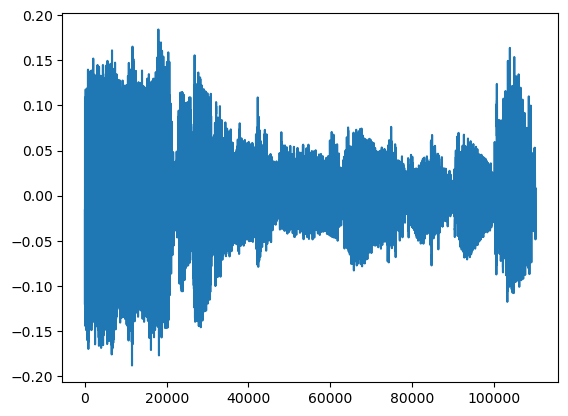

In [25]:
plt.plot(audio_data[0])

In [26]:
# Pick a random audio clip
random_index = np.random.choice(len(audio_data), size=1, replace=False)
clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]
label = labels[random_index][0]

print(f"Label {label}")

# Play the clip
Audio(data=clip, rate=sfreq)

Label m00236.wav


In [27]:
from librosa.core import stft
from librosa.core import amplitude_to_db
from librosa.display import specshow

def calculate_spectrograms(audio_clips, n_fft=2048, hop_length=512, win_length=None):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """
    spectrograms = []
    spectrograms_db = []

    for clip in audio_clips:
        win_length = win_length or n_fft

        # Calculate the STFT. Use lr.stft() here.
        stft_matrix = stft(clip, n_fft=n_fft, hop_length=hop_length, win_length=win_length)



        # Calculate the magnitude of the STFT (spectrogram). Use np.abs() here.
        spectrogram = np.abs(stft_matrix)



        # Convert to decibels. Use amplitude_to_db() here.
        deci = amplitude_to_db(spectrogram, ref=np.max)


        # Append the spectrogram to the list
        spectrograms.append(spectrogram)



        # Append spectrogram in decibels to the list
        spectrograms_db.append(deci)



    return spectrograms, spectrograms_db

# Use function
spectrograms, spectrograms_db = calculate_spectrograms(audio_data, n_fft=2048, hop_length=512, win_length=None)



Label m00637.wav


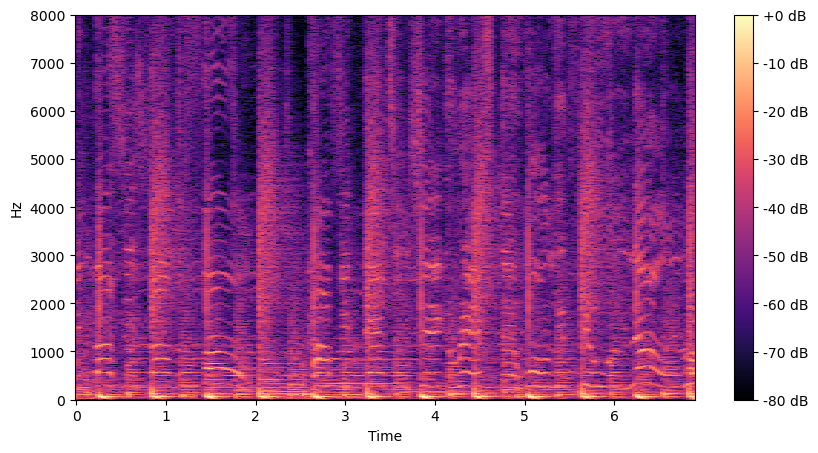

In [28]:
# Pick a random spectrogram
random_index = np.random.choice(len(spectrograms_db), size=1, replace=False)
spectrogram = spectrograms_db[random_index[0]]
clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]
label = labels[random_index][0]

print(f"Label {label}")

# Display the spectrogram
plt.figure(figsize=(10, 5))
img = specshow(spectrogram, x_axis='time', y_axis='hz', sr=16000, hop_length=512)
plt.colorbar(img, format='%+2.0f dB')
plt.show()

# Play the corresponding clip
Audio(data=clip, rate=sfreq)

In [29]:
def calculate_spectral_features(spectrograms):
    """
    Calculate the centroid and bandwidth for each spectrogram in a list.

    Parameters:
    - spectrograms: A list of spectrograms.

    Returns:
    - bandwidths: A list of bandwidths corresponding to each spectrogram
    - centroids: A list of centroids corresponding to each spectrogram
    """
    bandwidths = []
    centroids = []

    for spectrogram in spectrograms:

        # Calculate the bandwidth for the spectrogram (use lr.feature.spectral_bandwidth)
        bandwidths.append(lr.feature.spectral_bandwidth(S=spectrogram))



        # Calculate the spectral centroid for the spectrogram (use lr.feature.spectral_centroid)
        centroids.append(lr.feature.spectral_centroid(S=spectrogram))



    return bandwidths, centroids

# Use function
bandwidths, centroids = calculate_spectral_features(spectrograms)

Label m00236.wav


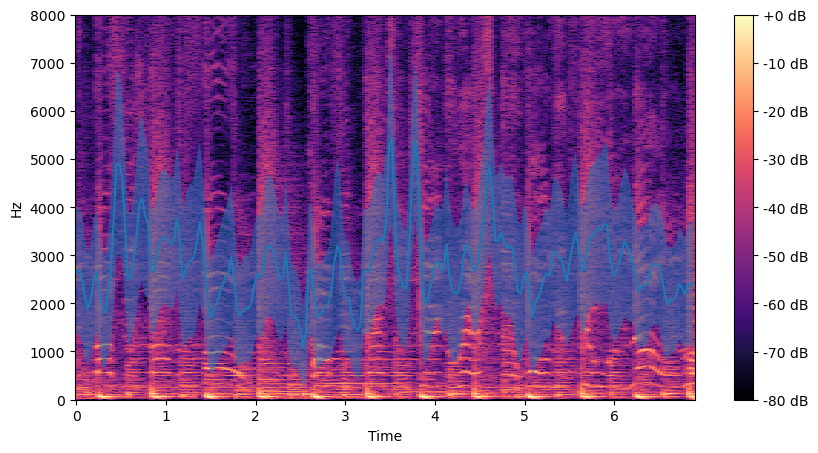

In [30]:
# Pick a random spectrogram
random_index = np.random.choice(len(spectrograms_db), size=1, replace=False)
spectrogram = spectrograms_db[random_index[0]]

# Get time index values
times_spec = lr.frames_to_time(range(spectrogram.shape[1]), sr=16000, hop_length=512)

bw = bandwidths[random_index[0]][0]
cent = centroids[random_index[0]][0]

clip = audio_data[random_index][0]
sfreq = sample_freqs[random_index][0]
label = labels[random_index][0]

print(f"Label {label}")

# Display the spectrogram
plt.figure(figsize=(10, 5))
img = specshow(spectrogram, x_axis='time', y_axis='hz', sr=16000, hop_length=512)
plt.plot(times_spec, cent)
plt.fill_between(times_spec, cent - bw / 2, cent + bw / 2, alpha=.5)
plt.colorbar(img, format='%+2.0f dB')
plt.show()

# Play the corresponding clip
Audio(data=clip, rate=sfreq)


In [31]:
mean_bw = np.mean(bandwidths)
mean_cent = np.mean(centroids)

In [32]:
features = pd.DataFrame(columns=['mean_bandwidth','mean_centroids'])

for i in range(len(bandwidths)):
    features.loc[i] = [np.mean(bandwidths[i]), np.mean(centroids[i])]

features.head()


,mean_bandwidth,mean_centroids
0,1966.890053,1439.764877
1,2012.207776,1769.254916
2,2961.971115,3050.586443
3,2548.466009,2240.970749
4,2635.935693,2793.609704


# Unsupervised Learning